In [1]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

In [6]:
!pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [7]:
def generate_dataset_from_directory(folder_path, size = 256,batch_size = 32): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, 
        samplewise_std_normalization= True,
        #rescale=1./255,
        validation_split = 0.3
    )
    #creating train and test dataset 
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=False,
        seed=123,
        subset="training"
    )
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=False,
        seed=123,
        subset="validation"
    )
    indices=train_data.class_indices
  
    return train_data, val_data,indices

In [8]:
folder_path = '/content/COVID-19_Radiography_Dataset/'
train_data, val_data, indices= generate_dataset_from_directory(
    folder_path, size = 256,batch_size = 32)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [ ]:
def cnn_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    i = Input(shape=(size,size,3))
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 8,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs

In [ ]:
epochs = 30
r,model,n_epochs = cnn_model(train_data, val_data,epochs,256)

----Building the model----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                            

DATA ANALYSIS OF MODEL


In [ ]:
class_names = train_data.class_indices
print(class_names)


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [ ]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [ ]:
images,labels = next(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wi

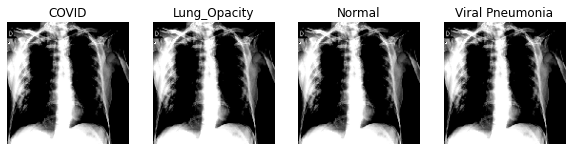

In [ ]:
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
            j = j+1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Raw Chest X Ray Image')

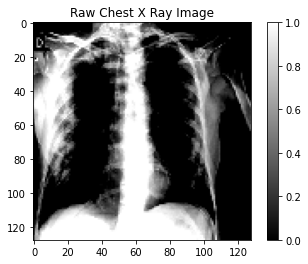

In [ ]:
raw_image = images[k]
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

In [ ]:
all_items,dirs,files = next(os.walk(folder_path))

In [ ]:
folder_path

'/content/COVID-19_Radiography_Dataset/'

In [ ]:
import seaborn as sns
image_in_classes = []
for i in range(len(dirs)):
    print(dirs[i])
    k=(os.path.join(folder_path,dirs[i]))
    k=os.path.join(k,'images/')
    # print(os.listdir(os.path.join(folder_path,dirs[i])))
    # no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    print(k)
    no_of_images =len(os.listdir(k))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data) 

Normal
/content/COVID-19_Radiography_Dataset/Normal/images/
Lung_Opacity
/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/
COVID
/content/COVID-19_Radiography_Dataset/COVID/images/
Viral Pneumonia
/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/


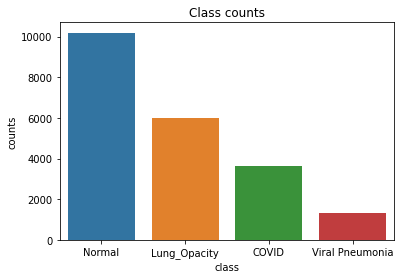

In [ ]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

In [ ]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

397/397 [==============================] - 47s 118ms/step - loss: 0.4867 - accuracy: 0.8246
Test Accuracy using CNN: 82.46%
926/926 [==============================] - 84s 91ms/step - loss: 0.3121 - accuracy: 0.8958
Train Accuracy using CNN: 89.58%


In [ ]:
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("model_aptos_final.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5
model.save_weights("model_aptos_final.h5")
print("Saved model to disk")

Saved model to disk


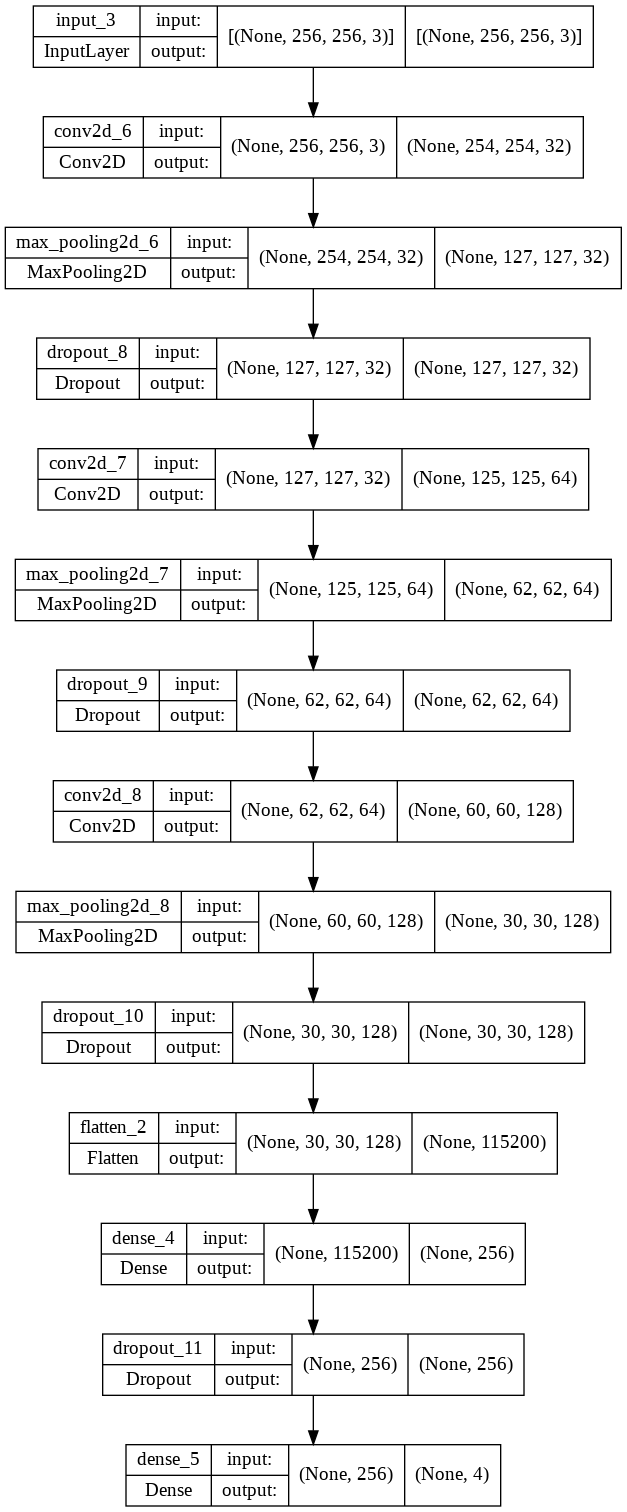

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[1756  203  196   14]
 [ 221 2738  628   20]
 [ 236  489 5331   59]
 [  17   32  112  646]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.79      0.81      0.80      2169
   Lung_Opacity       0.79      0.76      0.77      3607
         Normal       0.85      0.87      0.86      6115
Viral Pneumonia       0.87      0.80      0.84       807

       accuracy                           0.82     12698
      macro avg       0.83      0.81      0.82     12698
   weighted avg       0.82      0.82      0.82     12698



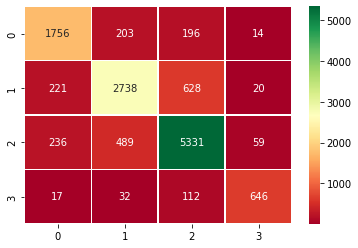

In [ ]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = model.predict_generator(train_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(train_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(train_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[ 4204   225   631     3]
 [  345  6980  1087     5]
 [  375   301 13536    57]
 [    2     5    52  1824]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.85      0.83      0.84      5063
   Lung_Opacity       0.93      0.83      0.88      8417
         Normal       0.88      0.95      0.92     14269
Viral Pneumonia       0.97      0.97      0.97      1883

       accuracy                           0.90     29632
      macro avg       0.91      0.89      0.90     29632
   weighted avg       0.90      0.90      0.90     29632



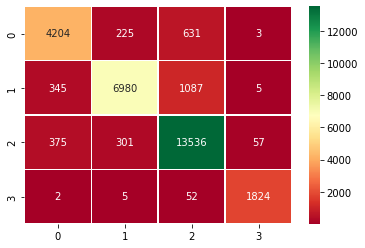

In [ ]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

ROC AUC score: 0.870786550295813


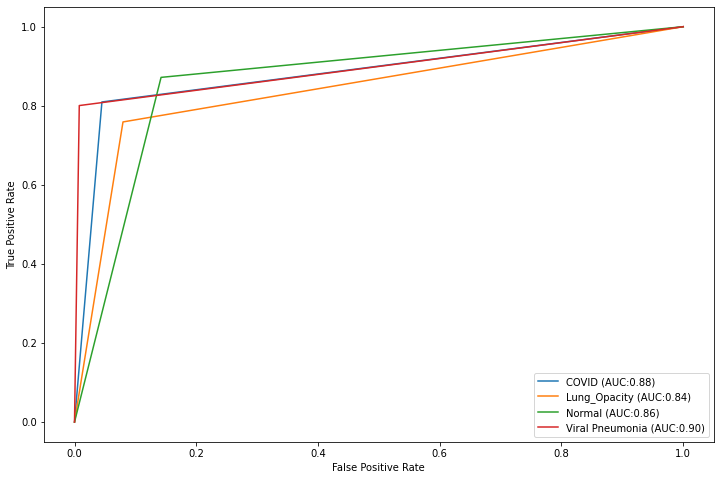

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= list(val_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.9256172956401598


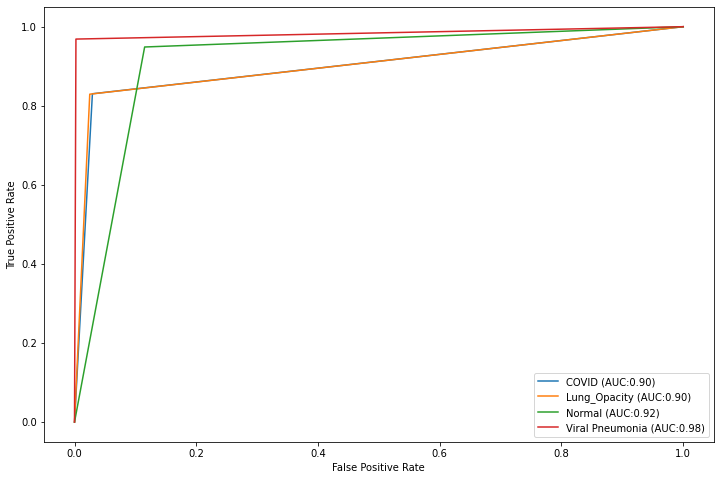

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Percentage of Data Present in Each type

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)


In [ ]:
labels.shape
#sns.heatmap(cn[0:], annot=labels, fmt='', cmap='Blues')

(2, 2)

In [ ]:
coviddat=cn[0]
coviddat=np.asarray(labels).reshape(2,2)

In [ ]:
sns.heatmap(coviddat, annot=labels, fmt='', cmap='Blues')

ValueError: ignored

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(float(value)) for value in coviddat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in coviddat.flatten()/np.sum(coviddat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(coviddat, annot=labels, fmt='', cmap='Blues')

ValueError: ignored

## **USING RESNET**

In [31]:
def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,3), include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [32]:
epochs = 20
r,model,n_epochs = resnet_model(train_data, val_data,epochs,256)

----Building the model----
94781440/94765736 [==============================] - 2s 0us/step
----Training the network----
Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = model.predict_generator(train_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(train_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(train_data.classes, y_pred, target_names=target_names))

In [ ]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  return roc_auc_score(y_test, y_pred, average=average)

y_score=multiclass_roc_auc_score(val_data.classes,y_pred)

In [ ]:
y_score

In [ ]:
train_data.classes.shape

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))

In [ ]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

In [ ]:
y_pred

In [ ]:
y_pred.shape

In [ ]:

# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset

Pred=model.predict(train_data)
# keep probabilities for the positive outcome only
lr_probs = Pred[:, 1]
# predict class values
yhat=np.argmax(Pred, axis=1)
#yhat = model.predict(testX)
testy=train_data.classes
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, y_pred, pos_label="curve")

In [ ]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

ROC AUC score: 0.6738368502529903


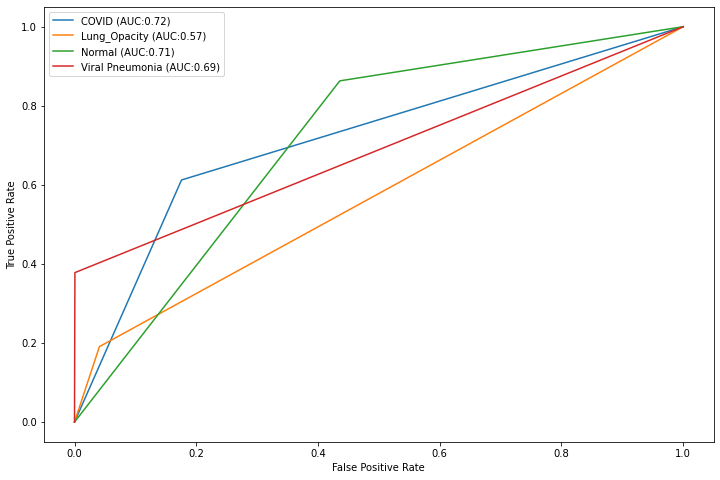

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.5502403125268125


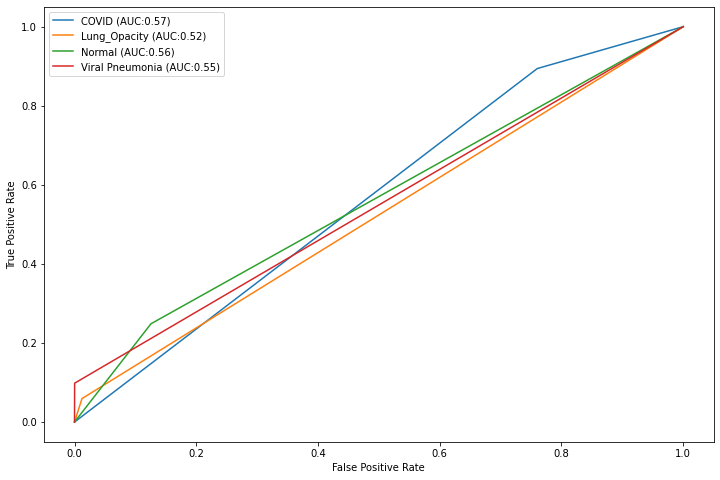

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("model_resnet_final.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5
model.save_weights("model_resnet_final.h5")
print("Saved model to disk")

Saved model to disk


VGG NET model

In [9]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

image_size=256

base_VGG = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3),
                                       include_top=False, 
                                       weights='imagenet')
base_VGG.trainable = False

# Add some layers which we found to be 
VGG = tf.keras.Sequential([
        base_VGG,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
        ])

# Compile our model
VGG.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy', 'Recall', 'Precision'])
VGG.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 31,494,468
Trainable params: 16,779,780
Non-trainable params: 14,714,688
____________________________________

In [10]:
print(len(base_VGG.layers))

19


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='best_weights.VGG', 
                             save_best_only=True 
                             #save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [12]:
histVGG = VGG.fit(
    train_data, 
    steps_per_epoch = 128, 
    epochs = 30, 
    validation_data = val_data, 
    callbacks= [checkpoint, lr_reduce])

Epoch 1/30
128/128 [==============================] - 123s 845ms/step - loss: 1.6048 - accuracy: 0.4368 - recall: 0.4023 - precision: 0.4513 - val_loss: 0.5268 - val_accuracy: 0.3572 - val_recall: 0.3447 - val_precision: 0.3554 - lr: 0.0010
Epoch 2/30
128/128 [==============================] - 110s 868ms/step - loss: 0.4546 - accuracy: 0.5771 - recall: 0.5122 - precision: 0.6297 - val_loss: 0.3623 - val_accuracy: 0.6765 - val_recall: 0.6628 - val_precision: 0.7055 - lr: 0.0010
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.6331 - recall: 0.5735 - precision: 0.6815INFO:tensorflow:Assets written to: best_weights.VGG/assets

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
128/128 [==============================] - 110s 863ms/step - loss: 0.4180 - accuracy: 0.6331 - recall: 0.5735 - precision: 0.6815 - val_loss: 0.3089 - val_accuracy: 0.7817 - val_recall: 0.6746 - val_precision: 0.8318 - lr: 0.0010
Epoch 4/30
128/128 [

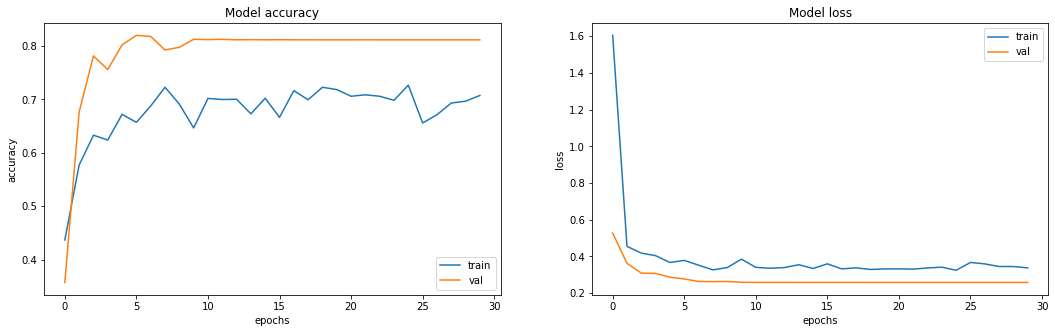

In [15]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(histVGG.history[element])
    axis[i].plot(histVGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [17]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = VGG.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[ 968  599  588   14]
 [  67 2887  653    0]
 [  25  323 5711   56]
 [   8    5   53  741]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.91      0.45      0.60      2169
   Lung_Opacity       0.76      0.80      0.78      3607
         Normal       0.82      0.93      0.87      6115
Viral Pneumonia       0.91      0.92      0.92       807

       accuracy                           0.81     12698
      macro avg       0.85      0.77      0.79     12698
   weighted avg       0.82      0.81      0.80     12698



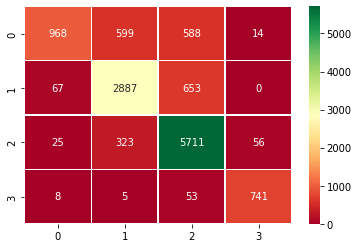

In [19]:
import seaborn as sns
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

In [21]:
test_evaluation = VGG.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = VGG.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

397/397 [==============================] - 79s 200ms/step - loss: 0.2581 - accuracy: 0.8117 - recall: 0.7622 - precision: 0.8433
Test Accuracy using CNN: 81.17%
926/926 [==============================] - 184s 198ms/step - loss: 0.3208 - accuracy: 0.7214 - recall: 0.6652 - precision: 0.7559
Train Accuracy using CNN: 72.14%


In [23]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = VGG.predict_generator(train_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(train_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(train_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[  899  2069  2089     6]
 [   73  6564  1780     0]
 [   52  1307 12868    42]
 [  103    60   673  1047]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.80      0.18      0.29      5063
   Lung_Opacity       0.66      0.78      0.71      8417
         Normal       0.74      0.90      0.81     14269
Viral Pneumonia       0.96      0.56      0.70      1883

       accuracy                           0.72     29632
      macro avg       0.79      0.60      0.63     29632
   weighted avg       0.74      0.72      0.69     29632



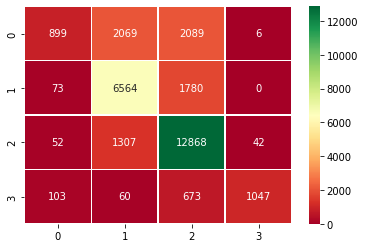

In [24]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

ROC AUC score: 0.7433299643095551


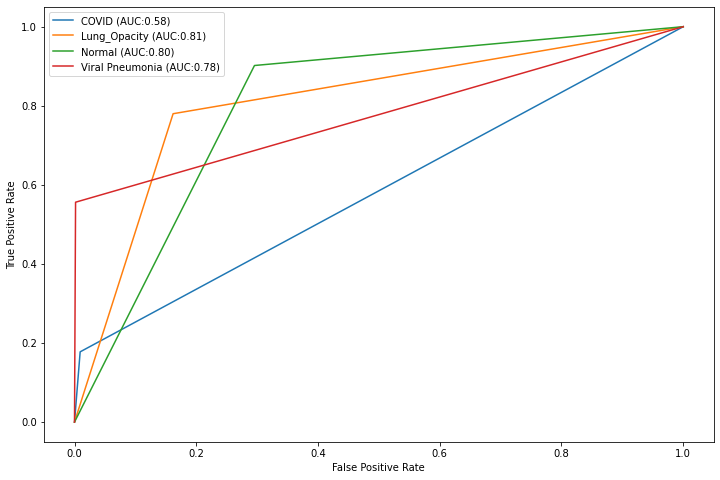

In [25]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [27]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = VGG.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[ 968  599  588   14]
 [  67 2887  653    0]
 [  25  323 5711   56]
 [   8    5   53  741]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.91      0.45      0.60      2169
   Lung_Opacity       0.76      0.80      0.78      3607
         Normal       0.82      0.93      0.87      6115
Viral Pneumonia       0.91      0.92      0.92       807

       accuracy                           0.81     12698
      macro avg       0.85      0.77      0.79     12698
   weighted avg       0.82      0.81      0.80     12698



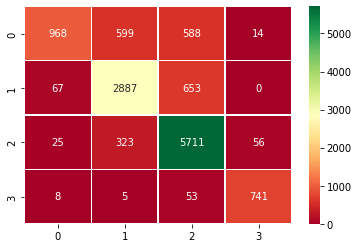

In [28]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

ROC AUC score: 0.8481131291541373


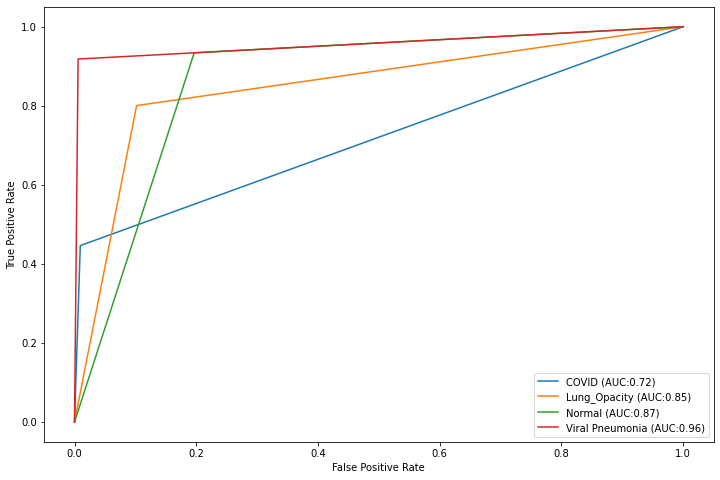

In [29]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

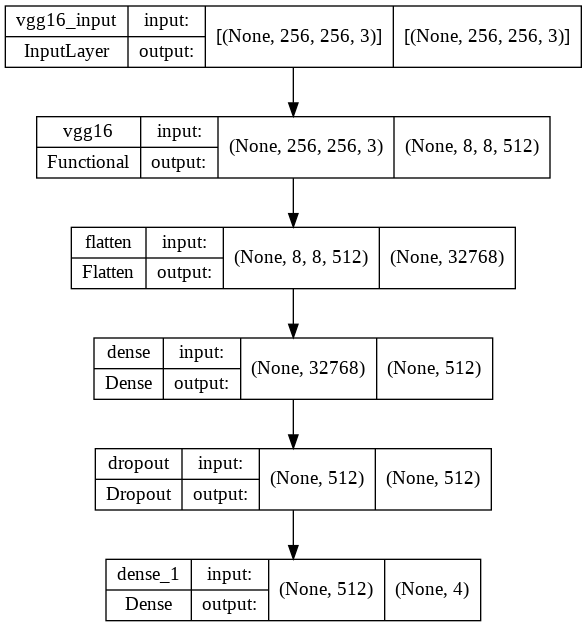

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(VGG, to_file='model_plot_VGG.png', show_shapes=True, show_layer_names=True)

SVM

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config) 
from keras.callbacks import ModelCheckpoint


In [ ]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [ ]:
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution64
cnn.add(tf.keras.layers.Conv2D(filters=128,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=64,padding='same',kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a third convolutional layer and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=7, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a 4th convolutional layer and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=16,padding='same',kernel_size=9, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))

In [ ]:
## for mulitclassification
cnn.add(Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'squared_hinge')

In [ ]:

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        204864    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 32)          100384    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 32)        

In [ ]:
# Part 3 - Training the CNN

# Compiling the CNN

# cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])
cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = train_data, validation_data = val_data, epochs = 10)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
evaluation = cnn.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = cnn.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")


In [33]:
model_mae_scores_dict = {'CNN': 90, 'VGG16' : 72.14, 'ResNet50' : 50}
model_mae_scores = pd.Series(model_mae_scores_dict)
model_mae_scores


CNN         90.00
VGG16       72.14
ResNet50    50.00
dtype: float64

In [34]:
order = model_mae_scores.sort_values()

Text(0.5, 1.0, 'Accuracy comparison')

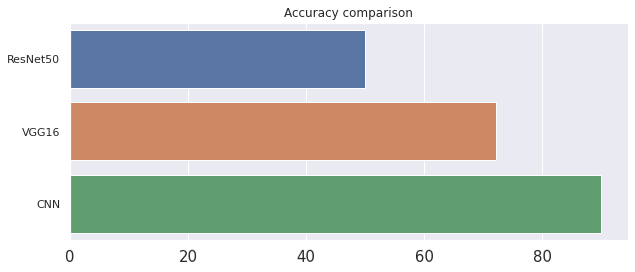

In [45]:
from matplotlib import pyplot
import seaborn as sns

sns.set_theme(style="ticks")
# sns.set_context('paper')
sns.set(rc={'figure.figsize':(10,4)})
sns.barplot(x=order.values, y = order.index,orient="h")
# sns.barplot(x=order.index,y=order.index,orient="h")

plt.xticks(rotation=1,fontsize=15)
plt.title('Accuracy comparison')